[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pierclgr/Face-GAN/blob/master/Face-GAN.ipynb)
# Project \#3 - Face generation

### Deep Learning course -  A.Y. 2019-2020

Students:
- Simone Gayed Said
- Pierpasquale Colagrande


# Versatile Auxiliary Classifier with Generative Adversarial Network (VAC+GAN)

## Import of fundamental libraries


In [1]:
%tensorflow_version 2.x

In [2]:
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_v3 import  InceptionV3
from tensorflow.keras.utils import plot_model
from scipy.linalg import sqrtm
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from zipfile import ZipFile
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



## Input and parameter definition
Definition of useful constants, like image sizes and batch size. The Dataset will be loaded from a folder in your Google Drive.<br> Use the form on the right to insert the name of the folder on your Google Drive.

In [3]:
BATCH_SIZE = 100                                          # Batch size dimension
ORIGINAL_IMAGE_SIZE = (218, 178, 3)                       # Dataset image size
TARGET_IMAGE_SIZE = (64, 64, 3)                           # Generated image size
NUM_IMAGES = 202599                                       # Number of images in dataset

# Folder on your Google Drive where all the checkpoints will be saved and where the dataset files are stored and loaded from
FOLDER_NAME = "Face Generation"                           # @param {type: "string"}
DATA_DRIVE_FOLDER = "drive/My Drive/" + FOLDER_NAME +"/"  # Full path to Drive folder
CELEBA_FILE = "img_align_celeba.zip"                      # Dataset zip containing images
CELEBA_IMAGE_FOLDER = "img_align_celeba/"                 # Folder inside zip which contains the images
ATTRIBUTE_FILE = "list_attr_celeba.txt"                   # Dataset attribute

Definition of a function that extracts the images and the related labels respectively from the dataset zip and txt file, in order to preprocess them and to prepare both for training. The dataset is then loaded as a generator, which can return a batch of images and relative attributes every time a batch is needed.

In [4]:
# Function that creates a generator for CelebA dataset by opening the zip file loaded in the Google Drive folder and by extracting batches images from it.
# It also preprocess the loaded images by reshaping and cropping them.
# It uses the defined BATCH_SIZE and the txt file to get the attributes corresponding to the file.
def celeba_generator():
  # Create a Numpy matrix containing all the attributes for each image file, along with image file name
  attributes = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))

  # Open dataset zip file
  with ZipFile(DATA_DRIVE_FOLDER + CELEBA_FILE, 'r') as img_dataset_file:                                                
    while True:
      # Pick a random batch of images from the dataset, in particular pick a random batch of filenames and relative attributes from the list
      batch_images_info = attributes[np.random.choice(attributes.shape[0], BATCH_SIZE, replace=False)]
      images_batch = []
      attributes_batch = []

      # For each image file in the batch, extract attributes and preprocess the image
      for image_info in batch_images_info:
        # Extract the image from the zip file on Google Drive using the filename in the list and refactor each pixel value from 0:255 to -1:1
        image = (cv2.imdecode(np.frombuffer(img_dataset_file.read(CELEBA_IMAGE_FOLDER + image_info[0]), np.uint8), cv2.IMREAD_COLOR)[...,::-1] - 127.5)/ 127.5

        # Crop and reshape the image, then add it to the batch of images
        image = image[45:173 , 25:153]
        image = cv2.resize(src=image, dsize=(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]))
        images_batch += [image]

        # Pick the attributes for the extracted image, change each -1 attribute to 0 and add the attributes to the batch of attributes
        image_attributes = image_info[1:] 
        image_attributes[image_attributes == -1] = 0
        attributes_batch += [image_attributes]

      # Convert image and attribute batches to Numpy array and return them
      images_batch = np.array(images_batch, dtype=np.float32)
      attributes_batch = np.array(attributes_batch, dtype=np.float32)
      
      yield [images_batch, attributes_batch]

# Define the training dataset as a generator
training_dataset = celeba_generator()

Definition of a function that shows 25 images from a batch.

In [5]:
# This function shows 25 images from a batch of images
def show_batch(image_batch):
  # Define the onscreen size of the image
  plt.figure(figsize=(10, 10))

  # For each of 25 images from the batch
  for n in range(25):
    # Plot the image with pixel values refracted from -1/1 to 0/255
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(((image_batch[n] * 127.5) + 127.5) / 255)
    plt.axis('off')
  
  # Plot the images
  plt.show()

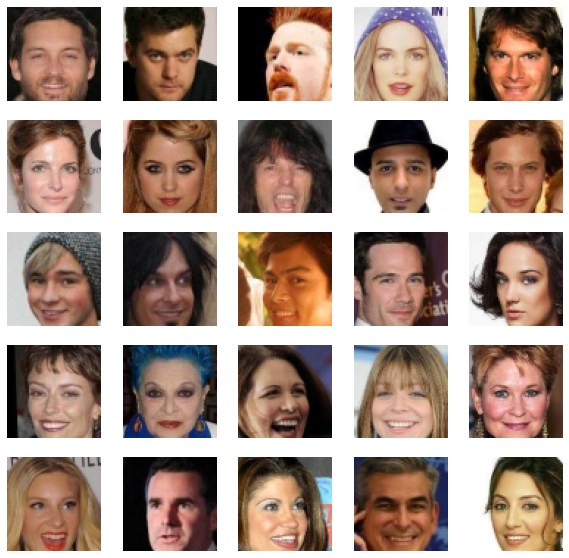

In [6]:
# Extract a batch from the training set and plot only the images
images = next(training_dataset)[0]
show_batch(images)

## Network model
In this section, we will define and build all the models used for the training of the GAN.
First, we define some other useful constants.

In [7]:
Z_LEN = 100         # Latent space size
N_ATTRIBUTES = 40   # Number of attributes per images

Definition of discriminator, classifier and generator optimizers

In [8]:
# Definition of discriminator, classifier and generator optimizers
discriminator_optimizer = Adam(lr=0.0002, beta_1=0)
classifier_optimizer = Adam(lr=0.0002, beta_1=0)
generator_optimizer = Adam(lr=0.00005, beta_1=0)

Definition of a new Conv2D class, which extends the original Conv2D layer of Keras, able to use the Spectral Normalization.

In [9]:
# Class representing a Conv2D layer improved with the use of Spectral Normalization
class Conv2D(Conv2D):
  # Constructor
  def __init__(self, filters, spectral_normalization=False, **kwargs):
    self.spectral_normalization = spectral_normalization
    super(Conv2D, self).__init__(filters, **kwargs)

  # Layer build function
  def build(self, input_shape):
    self.u = self.add_weight(name='u', shape=(1, self.filters), initializer='uniform', trainable=False)
    super(Conv2D, self).build(input_shape)

  # Function that computes the spectral normalization if required
  def compute_spectral_normalization(self, training=True):
    # Spectrally Normalized Weight
    if self.spectral_normalization:
      # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
      W_shape = self.kernel.shape.as_list()

      # Flatten the Tensor
      # [out_channels, N]
      W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

      _u = self.u
      epsilon = 1e-4

      _v = K.dot(_u, W_mat) / (K.sum(K.dot(_u, W_mat) ** 2) ** 0.5 + epsilon)
      _u = K.dot(_v, K.transpose(W_mat)) / (K.sum(K.dot(_v, K.transpose(W_mat)) ** 2) ** 0.5 + epsilon)

      W_sn = K.sum(K.dot(_u, W_mat) * _v)

      if training:
        # Update estimated 1st singular vector
        self.u.assign(_u)

      return self.kernel / W_sn
    else:
      return self.kernel

  # Function that calculates the output of the layer
  def call(self, inputs, training=None):
    outputs = K.conv2d(inputs, self.compute_spectral_normalization(training=training),
                        strides=self.strides, padding=self.padding,
                        data_format=self.data_format,
                        dilation_rate=self.dilation_rate)

    if self.use_bias:
      outputs = K.bias_add(outputs, self.bias, data_format=self.data_format)

    if self.activation is not None:
      return self.activation(outputs)
    return outputs

  # Function to calculate the output shape
  def compute_output_shape(self, input_shape):
    return super(Conv2D, self).compute_output_shape(input_shape)

Definition of the generator network which generates new images.



In [10]:
# Function that defines the generator network which generates new images
def define_generator():
  input_attributes = Input(shape=(Z_LEN + N_ATTRIBUTES, ))

  x = Dense(2048)(input_attributes)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.2)(x)

  x = Dense(256 * 8 * 8)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.2)(x)

  x = Reshape((8, 8, 256))(x)

  x = UpSampling2D()(x)
  x = Conv2D(filters=128, kernel_size=5, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = UpSampling2D()(x)
  x = Conv2D(filters=64, kernel_size=5, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = UpSampling2D()(x)
  x = Conv2D(filters=3, kernel_size=5, padding='same', spectral_normalization=True)(x)
  x = Activation('tanh')(x)

  model = Model(inputs=input_attributes, outputs=x, name="generator")

  return model

In [11]:
generator = define_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              288768    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0 

Definition of the discriminator network that discriminates between real and fake images (the images generated by the generator).

In [12]:
# Function that defines the discriminator of the GAN which learns to discriminate between real and generated images
def define_discriminator(): 
  img_input = Input(shape=TARGET_IMAGE_SIZE)

  x = Conv2D(filters=32, kernel_size=5, strides=2,padding='same', spectral_normalization=True)(img_input)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=64, kernel_size=5, strides=2, padding='same', spectral_normalization=True)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=128, kernel_size=5, strides=2,padding='same', spectral_normalization=True)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', spectral_normalization=True)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = GlobalAveragePooling2D()(x)

  x = Dense(1)(x)

  model = Model(inputs=img_input, outputs=x,  name="discriminator")

  return model

In [13]:
discriminator = define_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2464      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51328     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         205056    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)       

Definition of the classifier, which learns to classify images, extracting features from them. The classifier has an important role for the conditionality of the network.

In [14]:
# Function that defines the classifier of images that influences the conditionality
def define_classifier():
  img_input = Input(shape=TARGET_IMAGE_SIZE)
  
  x = Conv2D(64, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(img_input)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(128, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(256, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(512, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = GlobalAveragePooling2D()(x)

  x = Dense(N_ATTRIBUTES, activation="sigmoid")(x)

  model = Model(inputs=img_input, outputs=x, name="classifier")

  return model

In [15]:
classifier = define_classifier()
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0

Definition of the losses for both the discriminator and the generator to be used during the training procedure to train the network.

In [16]:
# Inputs of the various networks
input_image = Input(shape=TARGET_IMAGE_SIZE)    # Input layer of real images
z = Input(shape=(Z_LEN + N_ATTRIBUTES, ))       # Input layer for the generator, made of noise and attributes
generated_image = generator(z)                  # Output of the generator (fake images)

# Output of the discriminator for both the input and generated images
logits_real = discriminator(input_image)        # Discriminator prediction for the real (dataset) images
logits_fake = discriminator(generated_image)    # Discriminator prediction for the fake (generated) images

# Predictions of the classifier for both the input and generated images
class_real = classifier(input_image)            # Classifier prediction for the real (dataset) images
class_fake = classifier(generated_image)        # Classifier prediction for the fake (generated) images

# Lightweight implementation of the Hinge loss
loss_real = K.mean(K.relu(1-logits_real))     
loss_fake = K.mean(K.relu(1+logits_fake))
    
# Loss for the discriminator 
discriminator_loss = (loss_real + loss_fake) / 2

# Loss for the generator 
generator_loss = - K.mean(logits_fake)

Definition of 4 more models, which are derived from the original discriminator, generator and classifier models. We prepare them for the training by using the previously defined losses and optimizers.

In [17]:
# Define discriminator and classifier as trainable and generator as not trainable
discriminator.trainable = True
classifier.trainable = True
generator.trainable = False

# Discriminator for the discrimination task, which distinguishes real from fake images
discriminator_train = Model(inputs=[input_image, z], outputs=[logits_real, logits_fake], name="discriminator_train")  # Define the model with input layers and output layers
discriminator_train.add_loss(discriminator_loss)                                                                      # Add the discriminator loss defined before to the discriminator training module
discriminator_train.compile(optimizer=discriminator_optimizer)                                                        # Compile the discriminator using its optimizer
discriminator_train.summary()                                                                                        

# Classifier for the classification task, which predicts labels for real images
classifier_train = Model(inputs=input_image, outputs=class_real, name="classifier_train")                             # Define the model with input layers and output layers              
classifier_train.compile(loss="binary_crossentropy", optimizer=classifier_optimizer)                                  # Compile the model using BCE as loss and its optimizer
classifier_train.summary()                                                                                            

Model: "discriminator_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 64, 64, 3)    34955078    input_5[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1078817     input_4[0][0]                    
                                                                 generator[1][0]

In [18]:
# Define generator as trainable and discriminator and classifier as not trainable
discriminator.trainable = False
classifier.trainable = False
generator.trainable = True

# Generator for the generation task, which creates fake images and pass them to the discriminator and returns its prediction (logits_fake)
generator_train = Model(inputs=z, outputs=logits_fake, name="generator_train")                            # Define the model with its inputs and outputs
generator_train.add_loss(generator_loss)                                                                  # Add the generator loss defined before
generator_train.compile(optimizer=generator_optimizer)                                                    # Compile the generator using its optimizer
generator_train.summary()                                                                                 

# Generator for the conditional generation task,  which creates fake images and pass them to the classifier and returns its prediction (class_fake)
generator_conditional_train = Model(inputs=z, outputs=class_fake, name="generator_conditional_train")     # Define the model with its inputs and outputs
generator_conditional_train.compile(loss = "binary_crossentropy", optimizer=generator_optimizer)          # Compile the generator using BCE as loss and its optimizer
generator_conditional_train.summary()                                                                    

Model: "generator_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
generator (Model)            (None, 64, 64, 3)         34955078  
_________________________________________________________________
discriminator (Model)        (None, 1)                 1078817   
_________________________________________________________________
tf_op_layer_Mean_2 (TensorFl [()]                      0         
_________________________________________________________________
tf_op_layer_Neg (TensorFlowO [()]                      0         
_________________________________________________________________
add_loss_1 (AddLoss)         ()                        0         
Total params: 36,033,895
Trainable params: 34,921,731
Non-trainable params: 1,112,164
_______________________________

## Training
We now train the network, but first we define new constants like the number of steps per epoch (number of batches), number of epochs and number of discriminator training iterations for epoch in order to balance discriminator and generator training. <br>
Use the form on the right to decide if you want to train the network or not and if you want to save weights or not. 

In [19]:
# @title Training

# Defines if the network will be trained
TRAIN = False                                           # @param {type:"boolean"}

# Defines if the weights will be saved
SAVE_WEIGHTS = True                                     # @param {type:"boolean"} 

NUM_TRAIN_DISC = 2                                      # Number of discriminator training iterations per epoch             
NUM_STEPS = NUM_IMAGES // (NUM_TRAIN_DISC * BATCH_SIZE) # Number of batches per epoch
NUM_EPOCHS = 25                                         # Number of epochs

In [20]:
# Create noise and attribute samples for generation purposes
SAMPLE_NUM = 25
sample_noise = np.random.normal(size=(SAMPLE_NUM, Z_LEN))
sample_class = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
sample_class = sample_class[np.random.choice(sample_class.shape[0], SAMPLE_NUM, replace=False)][:, 1:]
sample_class = sample_class.astype(np.int32)
sample_class[sample_class == -1] = 0
sample_combination = np.concatenate((sample_noise, sample_class), axis=1)

In [21]:
# Create training dataset as generator
training_dataset = celeba_generator()

In [22]:
# If training is requested, do the training
if TRAIN:
  # Create the lists containing respectively the discriminator and the generator losses
  discriminator_losses_list = []
  generator_losses_list = []

  # Epoch loop
  for epoch in range(NUM_EPOCHS):
    print("Starting Epoch {}".format(epoch + 1))
      
    # Batches (steps) loop
    for step in tqdm(range(NUM_STEPS)):
          
      # Discriminator training iteration loop
      for discriminator_iteration in range(NUM_TRAIN_DISC):

        # Extract a batch from the training dataset
        images, attributes = next(training_dataset)

        # Create a Numpy array of fake labels
        dumb = np.zeros_like(attributes)

        # Label smoothing
        attributes[attributes == 1] = 0.9

        # Create the input for the generator using noise and attributes combined
        noise = np.random.normal(size=(images.shape[0], Z_LEN))      # Generate random noise
        z_combined = np.concatenate((noise, attributes), axis=1)     # Concatenate noise and attributes 

        # Train the discriminator
        discriminator_loss = discriminator_train.train_on_batch([images, z_combined], dumb)

        # Train the classifier
        discriminator_loss = classifier_train.train_on_batch(images, attributes)

        # Add discriminator loss to the discriminator losses list
        discriminator_losses_list.append(discriminator_loss)

      # Train the generator
      generator_loss = generator_train.train_on_batch(z_combined, dumb)
      generator_loss = generator_conditional_train.train_on_batch(z_combined, attributes)

      # Add generator loss to the generator losses list
      generator_losses_list.append(generator_loss)

    # Print the losses for the current epoch
    print("Discriminator loss: {}".format(np.mean(discriminator_losses_list[-NUM_TRAIN_DISC * NUM_STEPS:])))
    print("Generator loss: {}".format(np.mean(generator_losses_list[-NUM_STEPS:])))

    # Generate a sample of images and plot it
    generator_sample = generator.predict(sample_combination)
    show_batch(generator_sample)

    # If requested, save weights to Google Drive
    if SAVE_WEIGHTS:
      print("Saving weights...")
      discriminator_train.save_weights(DATA_DRIVE_FOLDER + "weights/discriminator_train.h5")
      classifier_train.save_weights(DATA_DRIVE_FOLDER + "weights/classifier_train.h5")
      generator_train.save_weights(DATA_DRIVE_FOLDER + "weights/generator_train.h5")
      generator_conditional_train.save_weights(DATA_DRIVE_FOLDER + "weights/generator_conditional_train.h5")
      generator.save_weights(DATA_DRIVE_FOLDER + "weights/generator.h5")
      discriminator.save_weights(DATA_DRIVE_FOLDER + "weights/discriminator.h5")
      classifier.save_weights(DATA_DRIVE_FOLDER + "weights/classifier.h5")
      print()
      print("Weights saved.")

# If training is not requested, load weights from Google Drive
else:
  print("Loading weights...")
  discriminator_train.load_weights(DATA_DRIVE_FOLDER + "weights/discriminator_train.h5")
  classifier_train.load_weights(DATA_DRIVE_FOLDER + "weights/classifier_train.h5")
  generator_train.load_weights(DATA_DRIVE_FOLDER + "weights/generator_train.h5")
  generator_conditional_train.load_weights(DATA_DRIVE_FOLDER + "weights/generator_conditional_train.h5")
  generator.load_weights(DATA_DRIVE_FOLDER + "weights/generator.h5")
  discriminator.load_weights(DATA_DRIVE_FOLDER + "weights/discriminator.h5")
  classifier.load_weights(DATA_DRIVE_FOLDER + "weights/classifier.h5")
  print("Weights loaded.")

Loading weights...
Weights loaded.


# Test the network
Now, we test the trained network by generating sample images and by calculating the FID of the model.

## Random attributes


In [23]:
# Create noise and attribute samples for generation purposes
sample_noise = np.random.normal(size=(SAMPLE_NUM, Z_LEN))
sample_class = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
sample_class = sample_class[np.random.choice(sample_class.shape[0], SAMPLE_NUM, replace=False)][:, 1:]
sample_class = sample_class.astype(np.int32)
sample_class[sample_class == -1] = 0
sample_combination = np.concatenate( (sample_noise, sample_class), axis=1)

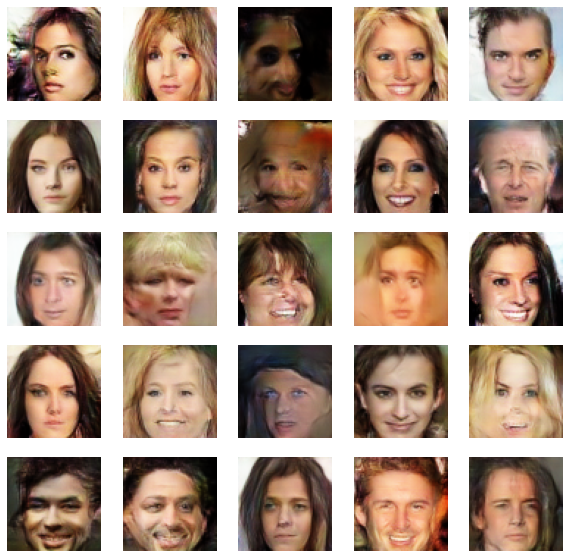

In [24]:
# Generate a sample of images and plot it
generated_sample = generator.predict(sample_combination)
show_batch(generated_sample)

## Select specific attributes
Select the attributes to use for the generation of new faces from the forms below. By default, a set of attributes from the dataset is chosen.

In [25]:
attributes = np.full(shape=(SAMPLE_NUM, N_ATTRIBUTES), fill_value=0, dtype=np.int32)

In [26]:
#@title Gender
Male = False #@param {type:"boolean"}
attributes[:,20] = int(Male)

In [27]:
#@title Age
Young = True #@param {type:"boolean"}
attributes[:,39] = int(Young)

In [28]:
#@title Face
Chubby = False #@param {type:"boolean"}
attributes[:,13] = int(Chubby)

Double_Chin = False #@param {type:"boolean"}
attributes[:,14] = int(Double_Chin)

High_Cheekbones = False #@param {type:"boolean"}
attributes[:,19] = int(High_Cheekbones)

Oval_Face = False #@param {type:"boolean"}
attributes[:,25] = int(Oval_Face)

Pale_Skin = False #@param {type:"boolean"}
attributes[:,26] = int(Pale_Skin)

Rosy_Cheeks = False #@param {type:"boolean"}
attributes[:,29] = int(Rosy_Cheeks)

Attractive = True #@param {type:"boolean"}
attributes[:,2] = int(Attractive)

In [29]:
#@title Hair
Bald = False #@param {type:"boolean"}
attributes[:,4] = int(Bald)

Receding_Hairline = False #@param {type:"boolean"}
attributes[:,28] = int(Receding_Hairline)

Sideburns =  False #@param {type:"boolean"}
attributes[:,30] = int(Sideburns)

Bangs = False #@param {type:"boolean"}
attributes[:,5] = int(Bangs)

Black_Hair = False #@param {type:"boolean"}
attributes[:,8] = int(Black_Hair)

Blonde_Hair = True #@param {type:"boolean"}
attributes[:,9] = int(Blonde_Hair)

Brown_Hair = False #@param {type:"boolean"}
attributes[:,11] = int(Brown_Hair)

Gray_Hair = False #@param {type:"boolean"}
attributes[:,17] = int(Gray_Hair)

Straight_Hair = False #@param {type:"boolean"}
attributes[:,32] = int(Straight_Hair)

Wavy_Hair = False #@param {type:"boolean"}
attributes[:,33] = int(Wavy_Hair)


In [30]:
#@title Eyes
Narrow_Eyes = False #@param {type:"boolean"}
attributes[:,23] = int(Narrow_Eyes)

Arched_Eyebrows = False #@param {type:"boolean"}
attributes[:,1] = int(Arched_Eyebrows)

Bushy_Eyebrows = False #@param {type:"boolean"}
attributes[:,12] = int(Bushy_Eyebrows)

Eyeglasses = False #@param {type:"boolean"}
attributes[:,15] = int(Eyeglasses)

Bags_Under_Eyes = False #@param {type:"boolean"}
attributes[:,3] = int(Bags_Under_Eyes)

In [31]:
#@title Nose
Big_Nose = False #@param {type:"boolean"}
attributes[:,7] = int(Big_Nose)

Pointy_Nose = False #@param {type:"boolean"}
attributes[:,27] = int(Pointy_Nose)

In [32]:
#@title Mouth
Big_Lips = False #@param {type:"boolean"}
attributes[:,6] = int(Big_Lips)

Mouth_Slightly_Open = False #@param {type:"boolean"}
attributes[:,21] = int(Mouth_Slightly_Open)

Smiling = True #@param {type:"boolean"}
attributes[:,31] = int(Smiling)

In [33]:
#@title Facial Hair
Goatee = False #@param {type:"boolean"}
attributes[:,16] = int(Goatee)

Mustache = False #@param {type:"boolean"}
attributes[:,22] = int(Mustache)

No_Beard = True #@param {type:"boolean"}
attributes[:,24] = int(No_Beard)

In [34]:
#@title Makeup
Heavy_Makeup = True #@param {type:"boolean"}
attributes[:,18] = int(Heavy_Makeup)

Wearing_Lipstick = False #@param {type:"boolean"}
attributes[:,36] = int(Wearing_Lipstick)

In [35]:
#@title Accessories
Wearing_Earrings = False #@param {type:"boolean"}
attributes[:,34] = int(Wearing_Earrings)

Wearing_Hat = False #@param {type:"boolean"}
attributes[:,35] = int(Wearing_Hat)

Wearing_Necklace = False #@param {type:"boolean"}
attributes[:,37] = int(Wearing_Necklace)

Wearing_Necktie = False #@param {type:"boolean"}
attributes[:,38] = int(Wearing_Necktie)

In [36]:
#@title Others
Five_o_Clock_Shadow = False #@param {type:"boolean"}
attributes[:,0] = int(Five_o_Clock_Shadow)

Blurry = False #@param {type:"boolean"}
attributes[:,10] = int(Blurry)

Plot the generated faces with the chosen attributes

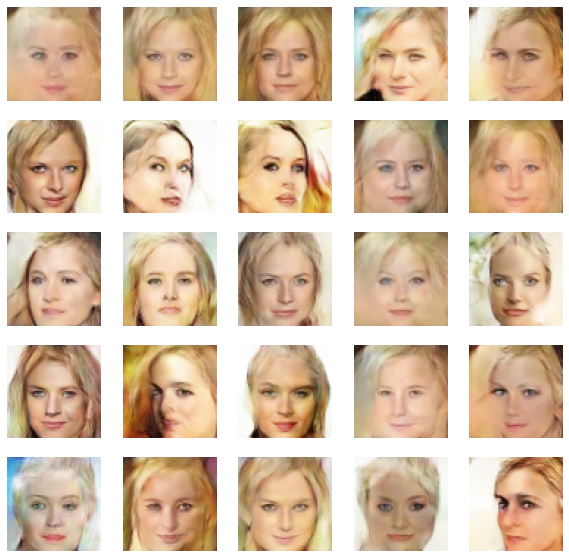

In [37]:
sample_noise = np.random.normal(size=(SAMPLE_NUM, Z_LEN))
sample_combination = np.concatenate((sample_noise, attributes), axis=1)
generated_sample = generator.predict(sample_combination)
show_batch(generated_sample)

## FID Score
We now calculate the FID score to evaluate the performance of the network.

In [38]:
# Function that resizes the images using bilinear interpolation
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# Resize with bilinear interpolation
		new_image = cv2.resize(image, (new_shape, new_shape))
		# Save the image
		images_list.append(new_image)
	return np.asarray(images_list)

# Function that calculates the FID between two batches of images
def calculate_fid(act1 , act2):
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  ssdiff = np.sum((mu1 - mu2)**2.0)
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

inception_model = InceptionV3(include_top=False, pooling='avg')

87916544/87910968 [==============================] - 1s 0us/step


Definition of a new function to ctrate a generator specific for the evaluation task.

In [39]:
# Function that defines the generator for evaluation.
# It is similar to the training dataset generator but it generates batches until the total number of batched images are 10000.
# This means that the evaluation of the FID is done on two batched sets, each of them of 10000 images in total.
def celeba_eval_generator():
  attributes = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
  attributes = attributes[np.random.choice(attributes.shape[0], 10000, replace=False)]
  with ZipFile(DATA_DRIVE_FOLDER + CELEBA_FILE, 'r') as img_dataset_file:
    batched = 0
    while batched < 10000:
      images = attributes[batched: batched + BATCH_SIZE]
      image_batch = []
      attributes_batch = []
      for image_info in images:
        image = (cv2.imdecode(np.frombuffer(img_dataset_file.read(CELEBA_IMAGE_FOLDER + image_info[0]), np.uint8), cv2.IMREAD_COLOR)[...,::-1] - 127.5)/ 127.5
        image = image [45:173 , 25:153]
        image = cv2.resize(src=image, dsize=(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]))
        image_batch += [image]
        labels = image_info[1:] 
        labels[labels == -1] = 0
        attributes_batch += [image_info[1:]]
      image_batch = np.array(image_batch, dtype=np.float32)
      attribute_batch = np.array(attributes_batch, dtype=np.int32)

      batched += BATCH_SIZE

      yield [image_batch, attribute_batch]

In [40]:
validation_dataset = celeba_eval_generator()
count = 1
pred_act = np.array([]).reshape((0, 2048))
img_act = np.array([]).reshape((0, 2048))
for batch in validation_dataset:
  images = batch[0]
  sample_class = batch[1]
  batch_size = images.shape[0]
  print("Batch", count)
  print("Num samples", batch_size)
  sample_noise = np.random.normal(size=(batch_size, Z_LEN))
  sample_combination = np.concatenate((sample_noise, sample_class), axis=1)
  predictions = generator.predict(sample_combination)
  images1 = scale_images(images, 299)
  images2 = scale_images(predictions, 299)
  a = inception_model.predict(images1)
  b = inception_model.predict(images2)
  img_act = np.concatenate((img_act, a), axis = 0)
  pred_act = np.concatenate((pred_act, b), axis = 0)
  count += 1

Batch 1
Num samples 100
Batch 2
Num samples 100
Batch 3
Num samples 100
Batch 4
Num samples 100
Batch 5
Num samples 100
Batch 6
Num samples 100
Batch 7
Num samples 100
Batch 8
Num samples 100
Batch 9
Num samples 100
Batch 10
Num samples 100
Batch 11
Num samples 100
Batch 12
Num samples 100
Batch 13
Num samples 100
Batch 14
Num samples 100
Batch 15
Num samples 100
Batch 16
Num samples 100
Batch 17
Num samples 100
Batch 18
Num samples 100
Batch 19
Num samples 100
Batch 20
Num samples 100
Batch 21
Num samples 100
Batch 22
Num samples 100
Batch 23
Num samples 100
Batch 24
Num samples 100
Batch 25
Num samples 100
Batch 26
Num samples 100
Batch 27
Num samples 100
Batch 28
Num samples 100
Batch 29
Num samples 100
Batch 30
Num samples 100
Batch 31
Num samples 100
Batch 32
Num samples 100
Batch 33
Num samples 100
Batch 34
Num samples 100
Batch 35
Num samples 100
Batch 36
Num samples 100
Batch 37
Num samples 100
Batch 38
Num samples 100
Batch 39
Num samples 100
Batch 40
Num samples 100
Batch 41


In [41]:
# Calculate FID score
print("Calculating score for generation...")
fid_score = calculate_fid(img_act, pred_act)
print("Score for generation:")
print(np.round(fid_score, 3))

Calculating score for generation...
Score for generation:
27.499
